# Test of SciNet with a force pendulum

### Creation of synthetic data for force pendulum + damping + little angles

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

import gc
from pathlib import Path

#### One damped forced pendulum with a constant forcing

In [183]:
def create_synthetic_damped_forced_pendulum(A, omega, b, L, g, theta0, omega0, t):
    """
    Create synthetic data for a damped forced pendulum with small angle approximation.

    Parameters:
    A (float): Amplitude of the forcing term.
    omega (float): Frequency of the forcing term.
    b (float): Damping coefficient.
    L (float): Length of the pendulum.
    g (float): Acceleration due to gravity.
    theta0 (float): Initial angle (in radians).
    omega0 (float): Initial angular velocity (in radians per second).
    t (numpy array): Time array.

    Returns:
    numpy array: Array of angles at each time step.
    """

    def pendulum_ode(t, y):
        theta, omega_t = y
        dtheta_dt = omega_t
        domega_dt = - (b / L) * omega_t - (g / L) * theta + A * np.cos(omega * t)
        return [dtheta_dt, domega_dt]

    y0 = [theta0, omega0]
    sol = solve_ivp(pendulum_ode, [t[0], t[-1]], y0, t_eval=t)
    
    return sol.y[0]  # Return only the angle array

In [184]:
A = 1.0
omega = 3.0
b = 0.5
L = 5.0
g = 9.81
theta0 = 0.1  # Initial angle in radians
omega0 = 0.0  # Initial angular velocity
t = np.linspace(0, 100, 10000)  # Time from 0 to 10 seconds

y = create_synthetic_damped_forced_pendulum(A, omega, b, L, g, theta0, omega0, t)

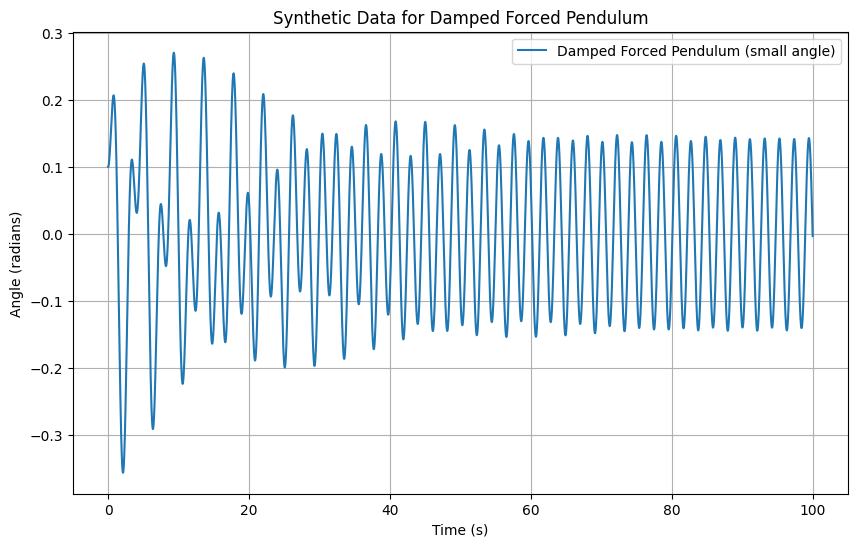

In [185]:
fig = plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Damped Forced Pendulum (small angle)')
plt.title('Synthetic Data for Damped Forced Pendulum')
plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.legend()
plt.grid()
plt.show()

#### Create complexe profil of forcing

-> trapezoidale shape

In [186]:
def create_trapezoidal_forcing(t, start_value, end_value, proportions, N_time_steps):
    """
    Create a trapezoidal forcing function.

    Args:
        t (numpy array): Time array.
        start_value (float): Initial value of the forcing.
        end_value (float): Value at the plateau of the trapezoid.
        proportions (list): List of 4 proportions [p1, p2, p3, p4] defining:
                        - from 0 to p1: constant value at start_value
                        - from p1 to p2: linear rise from start_value to end_value
                        - from p2 to p3: plateau at end_value
                        - from p3 to p4: linear fall from end_value to start_value
                        - from p4 to 1: constant value at start_value
        N_time_steps (int): Number of time steps. Theoretically len(t).

    Returns:
        array: Array of the trapezoidal forcing function.
    """
    assert len(t) == N_time_steps, "Length of time array must match N_time_steps"
    if len(proportions) != 4:
        raise ValueError("proportions must be a list of 4 values")

    p1, p2, p3, p4 = proportions
    if not (0 <= p1 <= p2 <= p3 <= p4 <= 1):
        raise ValueError("Proportions must be increasing and between 0 and 1")

    # Transition indices
    idx1 = int(p1 * N_time_steps)
    idx2 = int(p2 * N_time_steps)
    idx3 = int(p3 * N_time_steps)
    idx4 = int(p4 * N_time_steps)

    # Initialize the array
    omega_array = np.ones(N_time_steps) * start_value

    # Phase 1: Linear rise (p1 to p2)
    if idx2 > idx1:
        slope_up = (end_value - start_value) / (t[idx2] - t[idx1])
        omega_array[idx1:idx2] = start_value + slope_up * (t[idx1:idx2] - t[idx1])

    # Phase 2: Plateau (p2 to p3)
    omega_array[idx2:idx3] = end_value

    # Phase 3: Linear fall (p3 to p4)
    if idx4 > idx3:
        slope_down = (start_value - end_value) / (t[idx4] - t[idx3])
        omega_array[idx3:idx4] = end_value + slope_down * (t[idx3:idx4] - t[idx3])
    
    return omega_array

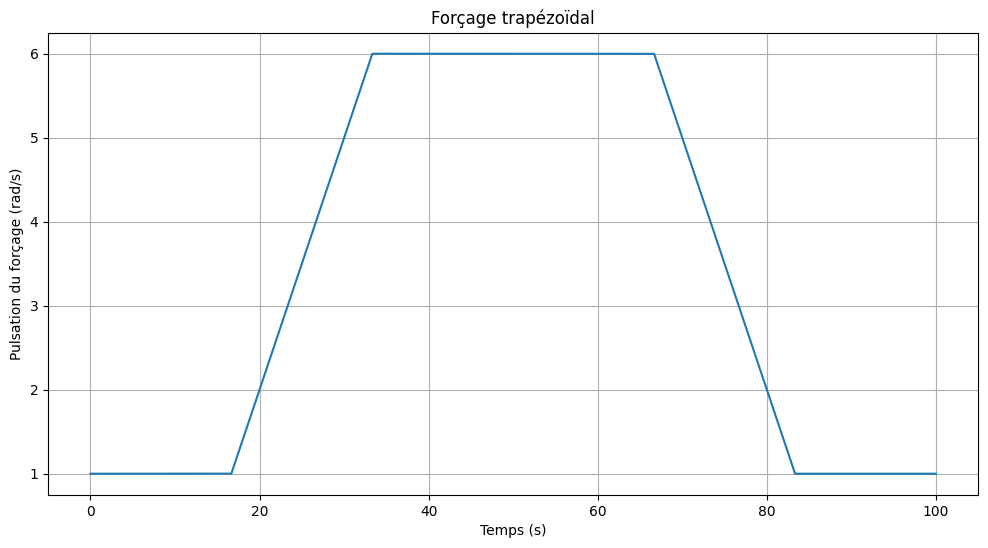

In [187]:
N_time_steps = 100000
t = np.linspace(0, 100, N_time_steps)

omega_array = create_trapezoidal_forcing(
    t=t,
    start_value=1.0,
    end_value=6.0,
    proportions=[1/6, 1/3, 2/3, 5/6],
    N_time_steps=N_time_steps
)

plt.figure(figsize=(12, 6))
plt.plot(t, omega_array)
plt.xlabel('Temps (s)')
plt.ylabel('Pulsation du forçage (rad/s)')
plt.title('Forçage trapézoïdal')
plt.grid(True)
plt.show()

#### Create pendulum with trapezoidal forcing

In [188]:
def create_synthetic_damped_forced_pendulum(A, omega_array, b, L, g, theta0, omega0, t):
    """
    Create synthetic data for a damped forced pendulum with small angle approximation
    and time-varying forcing frequency.

    Args:
        A (float or array-like): Amplitude of the forcing term (constant or time-varying).
        omega_array (numpy array): Array of forcing frequencies at each time step.
        b (float): Damping coefficient.
        L (float): Length of the pendulum.
        g (float): Acceleration due to gravity.
        theta0 (float): Initial angle (in radians).
        omega0 (float): Initial angular velocity (in radians per second).
        t (numpy array): Time array.

    Returns:
        numpy array: Array of angles at each time step.
    """
    # Check if omega_array has the same length as t
    if len(omega_array) != len(t):
        raise ValueError("omega_array must have the same length as t")
    # Check if A is constant or variable
    if np.isscalar(A):
        A_array = np.full_like(t, A)
    else:
        if len(A) != len(t):
            raise ValueError("If A is an array, it must have the same length as t")
        A_array = A


    def pendulum_ode(t, y):
        # Find the index of the current time step
        idx = np.abs(t_array - t).argmin()
        
        theta, omega_t = y
        dtheta_dt = omega_t
        # Use the forcing value corresponding to the current time
        domega_dt = - (b / L) * omega_t - (g / L) * theta + A_array[idx] * np.cos(omega_array[idx] * t)
        return [dtheta_dt, domega_dt]

    # Store the global time array for use in the ODE
    global t_array
    t_array = t.copy()
    
    y0 = [theta0, omega0]
    sol = solve_ivp(pendulum_ode, [t[0], t[-1]], y0, t_eval=t, method='RK45')
    
    return sol.y[0]  # Return only the angle array

In [209]:
# Time array
N_time_steps = 200
t = np.linspace(0, 100, N_time_steps)

# Variable pulsation (trapezoidal shape)
omega_array = create_trapezoidal_forcing(
    t=t,
    start_value=1.0,
    end_value=6.0,
    proportions=[1/6, 1/3, 2/3, 5/6],
    N_time_steps=N_time_steps
)
# Variables amplitudes or not
A_value = 1.0
A = np.ones(N_time_steps) * A_value
# Parameters
b = 0.1
L = 5.0
g = 9.81
theta0 = 0.1
omega0 = 0.0

y = create_synthetic_damped_forced_pendulum(A, omega_array, b, L, g, theta0, omega0, t)

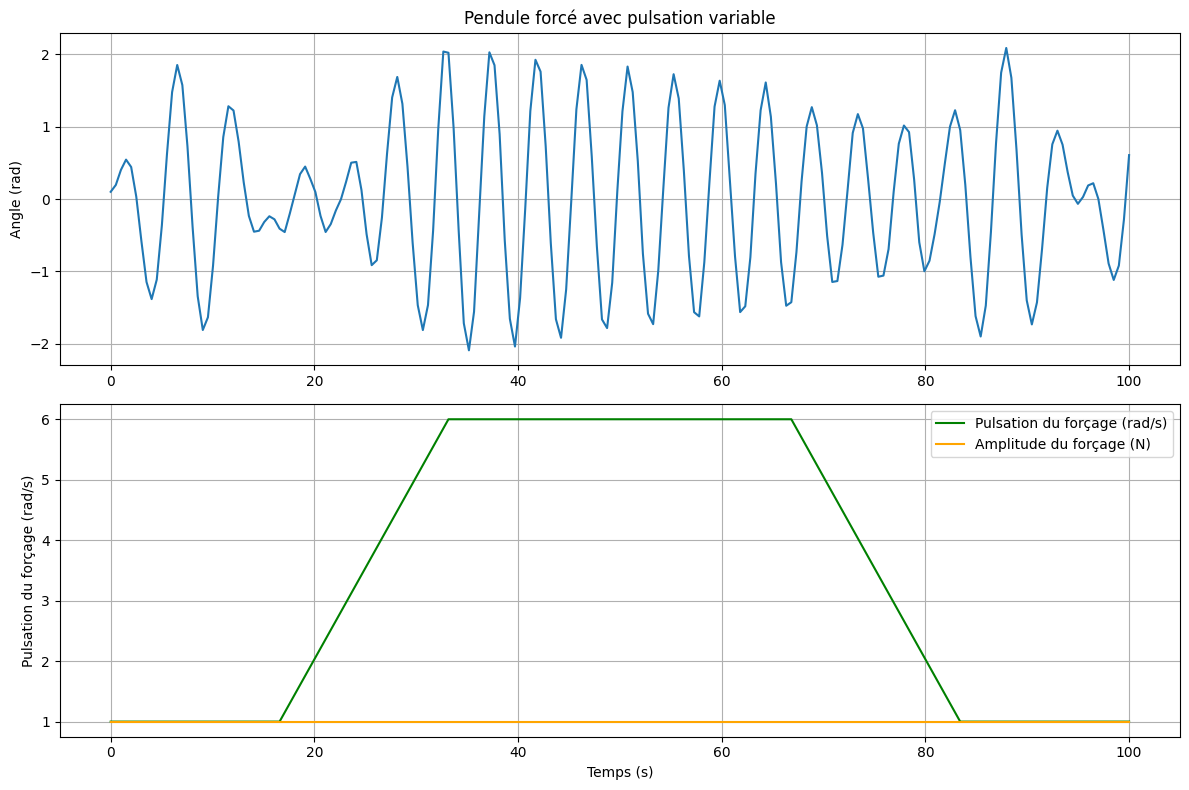

In [210]:
# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(t, y)
ax1.set_ylabel('Angle (rad)')
ax1.set_title('Pendule forcé avec pulsation variable')
ax1.grid(True)

ax2.plot(t, omega_array, color='green', label='Pulsation du forçage (rad/s)')
ax2.plot(t, A, color='orange', label='Amplitude du forçage (N)')
ax2.set_ylabel('Pulsation du forçage (rad/s)')
ax2.set_xlabel('Temps (s)')
ax2.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### Create Dataset of various parameters for differents forcing

* A: fixed
* g: fixed
* theta0: fixed
* omega0: fixed
* L: varying randomly
* b: varying randomly
* omega_forcing: choosen among a discret number


In [211]:
def create_dataset(
        N_sample: int, 
        maxtime: float, 
        n_timestep: int, 
        L_range: tuple, 
        b_range: tuple, 
        omega_forcing_values: dict,
        A_value: float = 1.0,
        g: int = 9.81, 
        theta0: float = 0.0, 
        omega0: float = 0.0
    ):
    """
    Create a dataset of synthetic damped forced pendulum data with varying parameters.

    Args:
        N_sample (int): Number of samples to generate.
        maxtime (float): Maximum time for the simulation.
        n_timestep (int): Number of time steps in the simulation.
        L_range (tuple): Tuple defining the range of lengths (min, max).
        b_range (tuple): Tuple defining the range of damping coefficients (min, max).
        omega_forcing_values (dict): dictionary of args for the forcing parameters.
    
    Parameters:
        A_value (float): Amplitude of the forcing term (constant).
        g (float): Acceleration due to gravity.
        theta0 (float): Initial angle (in radians).
        omega0 (float): Initial angular velocity (in radians per second).

    Returns:
        list: List of dictionaries containing parameters and corresponding angle arrays.
    """
    dataset = []
    t = np.linspace(0, maxtime, n_timestep)

    for _ in tqdm(range(N_sample)):
        # Choose forcing frequency parameters
        omega_start, omega_end = 1.0, 0.0
        while omega_start >= omega_end:
            omega_start = np.random.uniform(*omega_forcing_values["start_value"])
            omega_end = np.random.uniform(*omega_forcing_values["end_value"])
        proportions = [np.random.uniform(*omega_forcing_values["proportions"][a]) for a in range(4)]
        omega_forcing_values_sampled = {
            "start_value": omega_start,
            "end_value": omega_end,
            "proportions": proportions
        }
        # Randomly choose a forcing frequency from the provided values
        omega_forcing = create_trapezoidal_forcing(t=t, N_time_steps=n_timestep, **omega_forcing_values_sampled)

        # Randomly sample L and b within their respective ranges
        L = np.random.uniform(L_range[0], L_range[1])
        b = np.random.uniform(b_range[0], b_range[1])
        
        # Create the synthetic data
        y = create_synthetic_damped_forced_pendulum(A_value, omega_forcing, b, L, g, theta0, omega0, t)
        
        # Store the parameters and the resulting angle array
        sample = {
            'L': L,
            'b': b,
            'omega_forcing': omega_forcing,
            'time': t,
            'angle': y
        }
        
        dataset.append(sample)
    
    return dataset

In [212]:
eps = 1/13
trapezoid_range = [(1/6-eps, 1/6+eps), (1/3-eps, 1/3+eps), (2/3-eps, 2/3+eps), (5/6-eps, 5/6+eps)]
omega_forcing_ranges = {
    "start_value": (0.5, 2.0),
    "end_value": (1.0, 6.0),
    "proportions": trapezoid_range,
}

b_range = (0.01, 1.5)
L_range = (0.01, 8.0)
N_samples = 2000
N_time_steps = 200
max_time = 100.0

dataset = create_dataset(
    N_sample=N_samples,
    maxtime=max_time,
    n_timestep=N_time_steps,
    L_range=L_range,
    b_range=b_range,
    omega_forcing_values=omega_forcing_ranges
)

100%|██████████| 2000/2000 [01:44<00:00, 19.23it/s]


In [213]:
len(dataset)

2000

In [214]:
path = Path().absolute().parent / "data/raw/synthetic_damped_forced_pendulum_dataset.npy"
np.save(path, dataset)

In [215]:
dataset[0]

{'L': 1.0595156300059423,
 'b': 1.0424866285216092,
 'omega_forcing': array([0.67037021, 0.67037021, 0.67037021, 0.67037021, 0.67037021,
        0.67037021, 0.67037021, 0.67037021, 0.67037021, 0.67037021,
        0.67037021, 0.67037021, 0.67037021, 0.67037021, 0.67037021,
        0.67037021, 0.67037021, 0.67037021, 0.67037021, 0.67037021,
        0.67037021, 0.67037021, 0.67037021, 0.67037021, 0.67037021,
        0.67037021, 0.67037021, 0.67037021, 0.67037021, 0.77433949,
        0.87830878, 0.98227807, 1.08624735, 1.19021664, 1.29418593,
        1.39815521, 1.5021245 , 1.60609379, 1.71006307, 1.81403236,
        1.91800165, 2.02197093, 2.12594022, 2.22990951, 2.33387879,
        2.43784808, 2.54181737, 2.64578665, 2.74975594, 2.85372523,
        2.95769451, 3.0616638 , 3.16563309, 3.26960237, 3.37357166,
        3.47754095, 3.58151024, 3.68547952, 3.78944881, 3.8934181 ,
        3.99738738, 4.10135667, 4.20532596, 4.30929524, 4.41326453,
        4.51723382, 4.6212031 , 4.72517239, 4.8

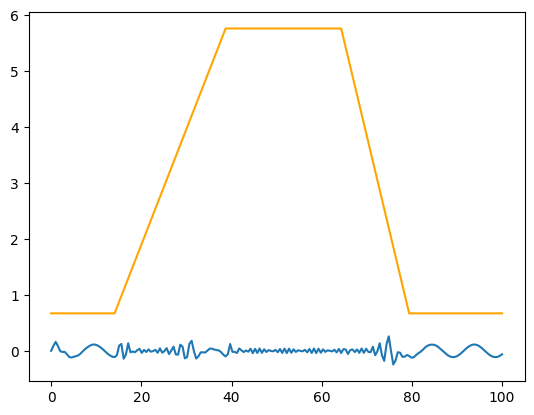

In [216]:
plt.plot(dataset[0]['time'], dataset[0]['angle'])
plt.plot(dataset[0]['time'], dataset[0]['omega_forcing'], color='orange')
plt.show()

#### Create dataloader for SciNet

In [245]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

In [246]:
class forced_pendulum_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        observations = torch.tensor(sample['angle'], dtype=torch.float32)
        questions = torch.tensor(sample['omega_forcing'], dtype=torch.float32)
        params = torch.tensor([sample['L'], sample['b']], dtype=torch.float32)
        return observations, questions, params

In [247]:
split_ratio = [0.6, 0.2, 0.2]  # Train, Validation, Test

train_size = int(split_ratio[0] * len(dataset))
val_size = int(split_ratio[1] * len(dataset))
test_size = len(dataset) - train_size - val_size

Dataset_custom = forced_pendulum_dataset(dataset)

train_dataset, val_dataset, test_dataset = random_split(Dataset_custom, [train_size, val_size, test_size])

In [248]:
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print("Types of datasets:", type(train_dataset), type(val_dataset), type(test_dataset))

Train size: 1200
Validation size: 400
Test size: 400
Types of datasets: <class 'torch.utils.data.dataset.Subset'> <class 'torch.utils.data.dataset.Subset'> <class 'torch.utils.data.dataset.Subset'>


In [249]:
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

#### Scinet network

In [250]:
class SciNetEncoder(nn.Module):
    def __init__(self, 
                 input_size: int = 1000, 
                 latent_size: int = 3, 
                 hidden_sizes: list[int] = [128, 64]
                 ) -> None:
        super().__init__()
        self.input_sizes = [input_size] + hidden_sizes[:-1]
        self.output_sizes = hidden_sizes
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))]
        )
        self.mean_layer = nn.Linear(hidden_sizes[-1], latent_size)
        self.logvar_layer = nn.Linear(hidden_sizes[-1], latent_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor]:
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar
    

class QuestionDecoder(nn.Module):
    def __init__(self, 
                 latent_size: int = 3, 
                 question_size: int = 1000, 
                 output_size: int = 1000, 
                 hidden_sizes: list = [128, 128]
                 ) -> None:
        super().__init__()
        self.input_sizes = [latent_size + question_size] + hidden_sizes
        self.output_sizes = hidden_sizes + [output_size]
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))] + [nn.Identity()]
        )

    def forward(self, z: torch.Tensor, question: torch.Tensor) -> torch.Tensor:
        z = torch.cat([z, question], dim=-1)
        for layer, activation in zip(self.layers, self.activations):
            z = activation(layer(z))
        return z


class PendulumNet(nn.Module):
    def __init__(self, 
                 input_size: int = 1000, 
                 enc_hidden_sizes: list[int] = [128, 64], 
                 latent_size: int = 3, 
                 question_size: int = 1000,
                 dec_hidden_sizes: list[int] = [128, 128], 
                 output_size: int = 1000
                 ) -> None:
        super().__init__()
        self.encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=enc_hidden_sizes)
        self.decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=dec_hidden_sizes)


    def forward(self, x, question):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        possible_answer = self.decoder(z, question)
        return possible_answer, mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std


In [251]:
def scinet_loss_forced_pendulum(
        possible_answer: torch.Tensor, 
        a_corr: torch.Tensor, 
        mean: torch.Tensor, 
        logvar: torch.Tensor, 
        beta: float = 0.003
        ) -> torch.Tensor:
    # prediction_loss = nn.MSELoss(reduction='none')(possible_answer, a_corr)
    # kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).unsqueeze(-1)
    # total_loss = prediction_loss + beta * kld_loss
    # return torch.mean(total_loss)

    recon_loss = torch.nn.MSELoss()(possible_answer.squeeze(), a_corr.squeeze())
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()
    return recon_loss + beta * kld_loss, kld_loss, recon_loss

#### Train scinet

In [252]:
from physical_parameters_SciNet.ml_tools.train_callbacks import EarlyStopping, GradientClipping, LRScheduling

In [289]:
def train_scinet(
        train_loader: DataLoader, 
        valid_loader: DataLoader,
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        num_epochs: int = 150, 
        kld_beta: float = 0.001, 
        early_stopper: EarlyStopping = None, 
        gradient_clipper: GradientClipping = None, 
        lr_scheduler: LRScheduling = None,
        device: torch.device = torch.device('cpu')
        ) -> None:
    
    torch.cuda.empty_cache()
    model.to(device)
    print("------training on {}-------\n".format(device))
    history = {'train_loss': [], 'valid_loss': []}
    print(f"{'Epoch':<20} ||| {'Train Loss':<15} ||| {'KLD Loss':<12} {'Recon Loss':<12} ||||||| {'Valid Loss':<15}")

    # Training
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        kld_loss, recon_loss = 0.0, 0.0
        for observations, questions, _ in tqdm(train_loader, desc="Training", leave=False):
            a_corr = observations.clone()
            observations = observations.to(device)
            questions = questions.to(device)
            a_corr = a_corr.to(device)

            optimizer.zero_grad()
            possible_answer, mean, logvar = model(observations, questions)
            loss, l_kld, l_recon = scinet_loss_forced_pendulum(possible_answer, a_corr, mean, logvar, beta=kld_beta)
            loss.backward()
            if gradient_clipper is not None:
                gradient_clipper.on_backward_end(model)
            optimizer.step()

            train_loss += loss.item() * observations.size(0)
            kld_loss += l_kld.item() * observations.size(0)
            recon_loss += l_recon.item() * observations.size(0)
        train_loss /= len(train_loader.dataset)
        kld_loss /= len(train_loader.dataset)
        recon_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Evaluation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for observations, questions, _ in tqdm(valid_loader, desc="Validation", leave=False):
                a_corr = observations.clone()
                observations = observations.to(device)
                questions = questions.to(device)
                a_corr = a_corr.to(device)

                possible_answer, mean, logvar = model(observations, questions)
                loss = scinet_loss_forced_pendulum(possible_answer, a_corr, mean, logvar, beta=kld_beta)[0]
                valid_loss += loss.item() * observations.size(0)
        
        valid_loss /= len(valid_loader.dataset)
        history['valid_loss'].append(valid_loss)

        print(f"{f'{epoch+1}/{num_epochs}':<20}  |  {train_loss:<15.6f}  |  {kld_loss:<12.6f} {recon_loss:<12.6f}    |    {valid_loss:<15.6f}")

        if early_stopper is not None:
            if early_stopper.check_stop(valid_loss, model):
                print(f"Early stopping at epoch {epoch + 1} with loss {valid_loss:.4f}")
                print(f"Restoring best weights for model.")
                early_stopper.restore_best_weights(model)
                break

        if lr_scheduler is not None:
            lr_scheduler.step(valid_loss)

        path = Path().absolute().parent / "results/model_params/checkpoints" / "pendulum_scinet_checkpointed.pth"
        torch.save(model.state_dict(), path)

        del observations, questions, a_corr, possible_answer, mean, logvar, loss, l_kld, l_recon
        torch.cuda.empty_cache()
        gc.collect()
    
    return history

In [290]:
def plot_history(history_train: list, history_valid: list) -> None:
    plt.figure(figsize=(8, 5))
    plt.plot(history_train, 'b-', linewidth=2, label='Train Loss')
    plt.plot(history_valid, 'r-', linewidth=2, label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    path = Path().absolute().parent / "results/figures" / "training_validation_loss.png"
    plt.savefig(path)
    return None

In [291]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [299]:
### SCINET architecture
TIMESTEPS = N_time_steps
M_INPUT_SIZE = TIMESTEPS
M_ENC_HIDDEN_SIZES = [500, 100, 100]
M_LATENT_SIZE = 3
M_QUESTION_SIZE = TIMESTEPS
M_DEC_HIDDEN_SIZES = [200, 200, 300]
M_OUTPUT_SIZE = TIMESTEPS

### Hyperparameters
BATCH_SIZE_TRAIN = 50
BATCH_SIZE_VALID = 50
FIRST_LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-5     # if needed
KLD_BETA = 0.0003

### Train parameters
NUM_EPOCHS = 50
ES_PATIENCE = 10
ES_MIN_DELTA = 5e-4
GC_MAX_NORM = 1.0
LRS_FACTOR = 0.66
LRS_PATIENCE = 5
LRS_MIN_LR = 1e-7
LRS_MIN_DELTA = 1e-4

In [300]:
pendulum_net = PendulumNet(
    input_size=M_INPUT_SIZE,
    enc_hidden_sizes=M_ENC_HIDDEN_SIZES,
    latent_size=M_LATENT_SIZE,
    question_size=M_QUESTION_SIZE,
    dec_hidden_sizes=M_DEC_HIDDEN_SIZES,
    output_size=M_OUTPUT_SIZE
)
optimizer = torch.optim.Adam(pendulum_net.parameters(), lr=FIRST_LEARNING_RATE, weight_decay=WEIGHT_DECAY)
early_stopper = EarlyStopping(patience=ES_PATIENCE, min_delta=ES_MIN_DELTA)
gradient_clipper = GradientClipping(max_norm=GC_MAX_NORM)
lr_scheduler = LRScheduling(optimizer, factor=LRS_FACTOR, patience=LRS_PATIENCE, min_lr=LRS_MIN_LR, min_delta=LRS_MIN_DELTA)

In [301]:
history = train_scinet(
    train_loader, 
    valid_loader, 
    pendulum_net, 
    optimizer, 
    num_epochs=NUM_EPOCHS, 
    kld_beta=KLD_BETA, 
    early_stopper=early_stopper, 
    gradient_clipper=gradient_clipper, 
    lr_scheduler=lr_scheduler,
    device=device
)

path = Path().absolute().parent / "results/model_params" / "pendulum_scinet_final.pth"
torch.save(pendulum_net.state_dict(), path)

------training on cuda-------

Epoch                ||| Train Loss      ||| KLD Loss     Recon Loss   ||||||| Valid Loss     


1/50                  |  0.791529         |  0.591295     0.791351        |    0.708261       


2/50                  |  0.757219         |  17.469113    0.751979        |    0.649053       


3/50                  |  0.709902         |  16.420828    0.704976        |    0.614542       


4/50                  |  0.650532         |  30.087723    0.641506        |    0.588819       


5/50                  |  0.605624         |  38.016717    0.594219        |    0.551915       


6/50                  |  0.574189         |  38.161998    0.562741        |    0.542547       


7/50                  |  0.559942         |  37.568480    0.548671        |    0.532282       


8/50                  |  0.538771         |  38.410686    0.527248        |    0.530207       


9/50                  |  0.527125         |  34.543195    0.516762        |    0.519909       


10/50                 |  0.519382         |  35.410833    0.508759        |    0.519552       


11/50                 |  0.504008         |  34.484738    0.493662        |    0.511957       


12/50                 |  0.495277         |  33.604963    0.485196        |    0.504319       


13/50                 |  0.482941         |  34.174105    0.472689        |    0.504503       


14/50                 |  0.476770         |  34.635564    0.466379        |    0.496653       


15/50                 |  0.470768         |  33.767450    0.460638        |    0.495800       


16/50                 |  0.465208         |  34.780066    0.454774        |    0.505386       


17/50                 |  0.458040         |  32.171012    0.448389        |    0.503463       


18/50                 |  0.453414         |  34.675967    0.443011        |    0.496993       


19/50                 |  0.448323         |  32.971396    0.438432        |    0.488449       


20/50                 |  0.444432         |  33.117299    0.434497        |    0.494048       


21/50                 |  0.432191         |  32.051989    0.422576        |    0.486371       


22/50                 |  0.428833         |  33.336922    0.418832        |    0.485228       


23/50                 |  0.421184         |  31.436364    0.411753        |    0.482963       


24/50                 |  0.422687         |  31.254551    0.413311        |    0.491602       


25/50                 |  0.415890         |  30.836149    0.406639        |    0.483090       


26/50                 |  0.411411         |  30.540327    0.402249        |    0.472468       


27/50                 |  0.406665         |  30.699154    0.397455        |    0.478275       


28/50                 |  0.403228         |  29.372662    0.394416        |    0.479877       


29/50                 |  0.399697         |  30.167659    0.390647        |    0.468244       


30/50                 |  0.406390         |  28.093990    0.397962        |    0.477471       


31/50                 |  0.397800         |  30.066865    0.388780        |    0.478273       


32/50                 |  0.399875         |  27.893264    0.391507        |    0.480920       


33/50                 |  0.392545         |  29.568720    0.383674        |    0.488638       


34/50                 |  0.393816         |  29.916638    0.384841        |    0.479224       
Reduced learning rate from 5.00e-04 to 3.30e-04


35/50                 |  0.380684         |  29.425592    0.371857        |    0.480176       


36/50                 |  0.374929         |  29.675961    0.366027        |    0.476243       


37/50                 |  0.371658         |  29.835744    0.362707        |    0.467669       


38/50                 |  0.365978         |  29.230034    0.357209        |    0.472458       


39/50                 |  0.364230         |  28.798443    0.355590        |    0.468557       


40/50                 |  0.362700         |  28.783756    0.354065        |    0.482887       


41/50                 |  0.360844         |  28.069365    0.352424        |    0.464437       


42/50                 |  0.359259         |  28.565709    0.350689        |    0.458324       


43/50                 |  0.361541         |  27.193447    0.353383        |    0.468549       


44/50                 |  0.355965         |  28.602553    0.347384        |    0.473528       


45/50                 |  0.355379         |  27.151338    0.347233        |    0.479062       


46/50                 |  0.354154         |  28.848941    0.345499        |    0.467824       


47/50                 |  0.355369         |  26.672850    0.347367        |    0.473301       
Reduced learning rate from 3.30e-04 to 2.18e-04


48/50                 |  0.345038         |  28.027670    0.336630        |    0.468796       


49/50                 |  0.342102         |  28.011394    0.333699        |    0.464470       


50/50                 |  0.340360         |  27.470294    0.332118        |    0.467245       


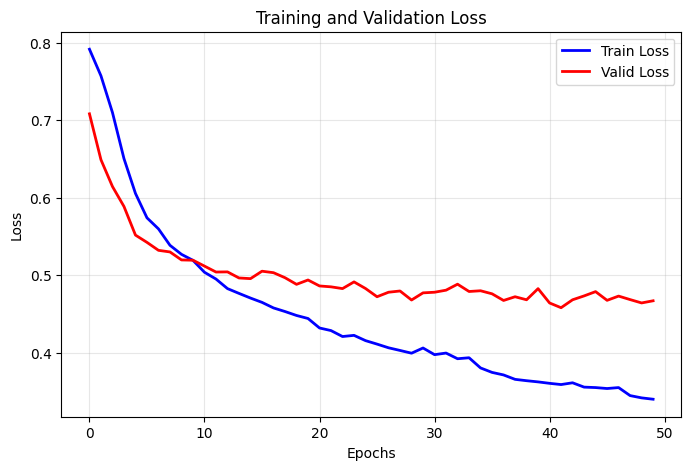

In [302]:
plot_history(history['train_loss'], history['valid_loss'])

#### Test pendulumenet

In [303]:
# Choose a sample from the test set
pendulum_net.eval()
with torch.no_grad():
    sample_idx = 0  # Change this index to test different samples
    observations, questions, params = test_dataset[sample_idx]
    observations = observations.unsqueeze(0).to(device)  # Add batch dimension
    questions = questions.unsqueeze(0).to(device)

    possible_answer, mean, logvar = pendulum_net(observations, questions)
    possible_answer = possible_answer.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU
    observations = observations.squeeze().cpu().numpy()
    questions = questions.squeeze().cpu().numpy()
    L, b = params.numpy()

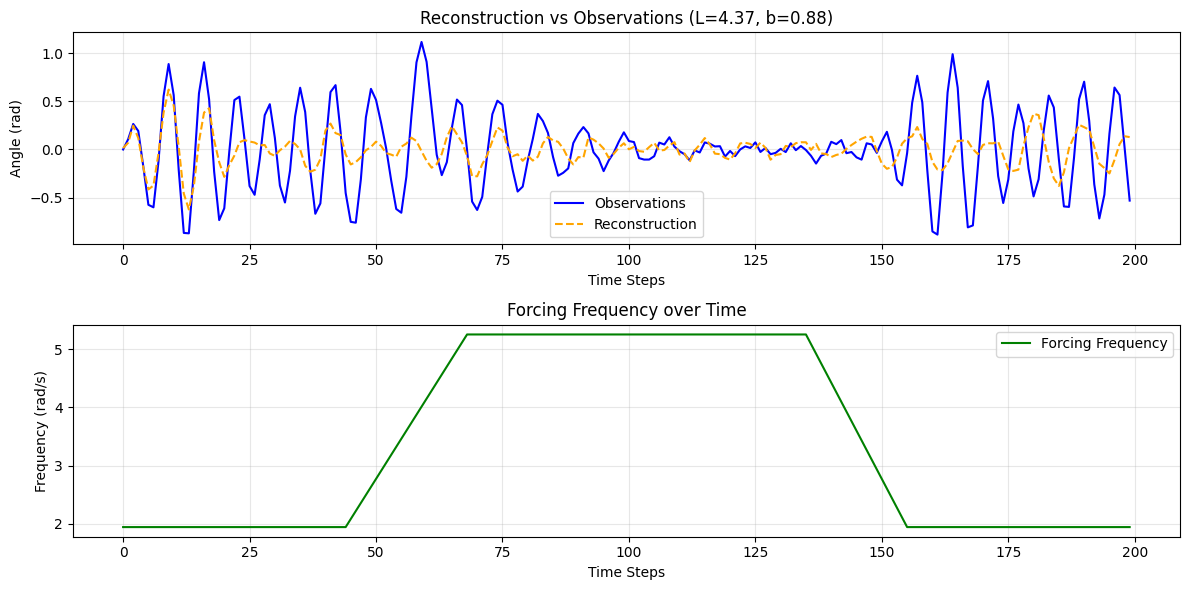

In [304]:
# Plot the results
# Fistly, plot the reconstruction and the observations
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(observations, label='Observations', color='blue')
plt.plot(possible_answer, label='Reconstruction', color='orange', linestyle='--')
plt.title(f'Reconstruction vs Observations (L={L:.2f}, b={b:.2f})')
plt.xlabel('Time Steps')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(2, 1, 2)
plt.plot(questions, label='Forcing Frequency', color='green')
plt.title('Forcing Frequency over Time')
plt.xlabel('Time Steps')
plt.ylabel('Frequency (rad/s)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

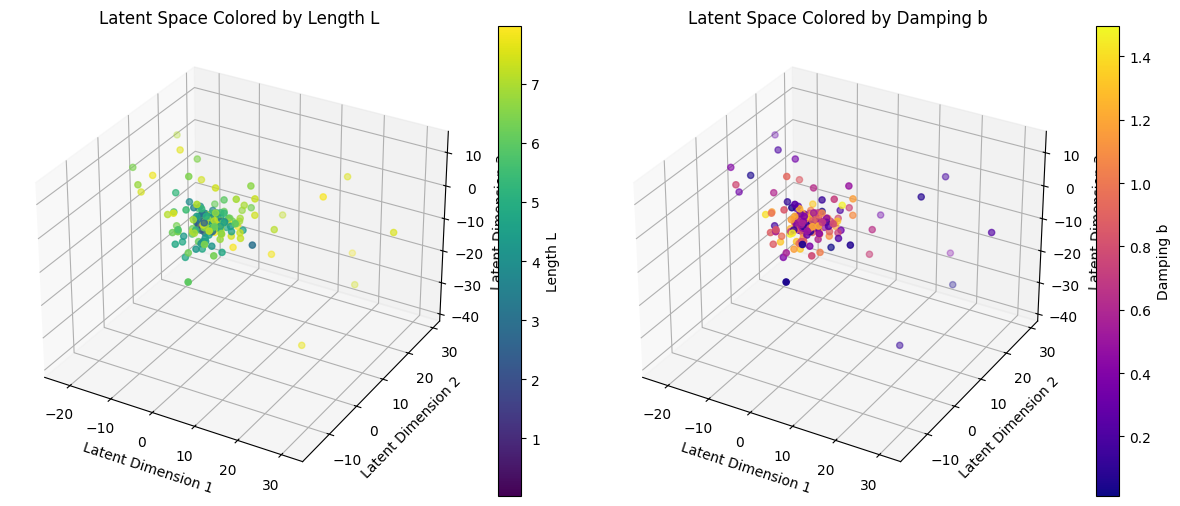

In [305]:
## Secondly, plot the latent space
all_means = []
all_params = []
pendulum_net.eval()
with torch.no_grad():
    for observations, questions, params in test_loader:
        observations = observations.to(device)
        questions = questions.to(device)
        mean, _ = pendulum_net.encoder(observations)
        all_means.append(mean.cpu().numpy())
        all_params.append(params.numpy())
all_means = np.concatenate(all_means, axis=0)
all_params = np.concatenate(all_params, axis=0)
L_values = all_params[:, 0]
b_values = all_params[:, 1]
latent_1 = all_means[:, 0]
latent_2 = all_means[:, 1]
latent_3 = all_means[:, 2]
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(131, projection='3d')
p = ax.scatter(latent_1, latent_2, latent_3, c=L_values, cmap='viridis')
fig.colorbar(p, ax=ax, label='Length L')
ax.set_title('Latent Space Colored by Length L')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
ax = fig.add_subplot(132, projection='3d')
p = ax.scatter(latent_1, latent_2, latent_3, c=b_values, cmap='plasma')
fig.colorbar(p, ax=ax, label='Damping b')
ax.set_title('Latent Space Colored by Damping b')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.tight_layout()
plt.show()